# Distances in representation space

This notebook reproduces figures 3, 4, 5, and 8 in the "What is a meaningful representation of protein sequences paper". All these experiments were done on the PFAM00144 alignment file, in contrast to figures 6 and 7, which were based on an alignment of the class A beta-lactamases. The latter can be found in the blat_class_A1A2_experiments.ipynb.

In [1]:
import os
import re
import numpy as np

%load_ext autoreload
%autoreload 2

try:
  import pytorch_lightning as pl
except: 
  !pip install pytorch-lightning==1.2.10
  import pytorch_lightning as pl

try:
  import torchplot
except: 
  !pip install torchplot
  import torchplot
    
try:
    from Bio import SeqIO
except:
    !pip install biopython
    from Bio import SeqIO
    
# Download repo if notebook is taken out of context (e.g. by colab)
if not os.path.exists('models'):
    !git clone https://github.com/MachineLearningLifeScience/What-is-a-meaningful-representation-of-protein-sequences tmp_clone
    !mv tmp_clone/* .
    !rm -rf tmp_clone

if not os.path.exists('PF00144_full_labeled.fasta'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_labeled.fasta

## Load data

In [2]:
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F

from models.vae_geometric import VAE, get_hparams, aa1_to_index, aa1, numeric_curve_optimizer

def get_data(data_filename, calc_weights=True, similarity_threshold=0.8):
    ids = []
    labels = []
    seqs = []
    label_re = re.compile(r'\[([^\]]*)\]')
    for record in SeqIO.parse(data_filename, "fasta"):
        ids.append(record.id)
        labels.append(label_re.search(record.description).group(1))
        seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
        
    seqs = torch.from_numpy(np.vstack(seqs))
    labels = np.array(labels)

    weights = None
    if calc_weights is not False:

        # Experiencing memory issues on colab for this code because pytorch doesn't
        # allow one_hot directly to bool. Splitting in two and then merging.
        # one_hot = F.one_hot(seqs.long()).to('cuda' if torch.cuda.is_available() else 'cpu')
        one_hot1 = F.one_hot(seqs[:len(seqs)//2].long()).bool()
        one_hot2 = F.one_hot(seqs[len(seqs)//2:].long()).bool()
        one_hot = torch.cat([one_hot1, one_hot2]).to('cuda' if torch.cuda.is_available() else 'cpu')
        assert(len(seqs) == len(one_hot))
        del one_hot1
        del one_hot2
        one_hot[seqs>19] = 0
        flat_one_hot = one_hot.flatten(1)

        weights = []
        weight_batch_size = 1000
        flat_one_hot = flat_one_hot.float()
        for i in range(seqs.size(0) // weight_batch_size + 1):
            x = flat_one_hot[i * weight_batch_size : (i + 1) * weight_batch_size]
            similarities = torch.mm(x, flat_one_hot.T)
            lengths = (seqs[i * weight_batch_size : (i + 1) * weight_batch_size] <=19).sum(1).unsqueeze(-1).to('cuda' if torch.cuda.is_available() else 'cpu')
            w = 1.0 / (similarities / lengths).gt(similarity_threshold).sum(1).float()
            weights.append(w)
            # plt.hist(similarities/lengths)
            
        weights = torch.cat(weights)
        neff = weights.sum()

    return ids, seqs, labels, weights

# Note that we deviate from the normal choice of 0.8 for the similarity threshold. This is 
# Due to the PFAM alignment being extremely long, with lots of positions matching gaps.
ids, data, labels, weights = get_data("PF00144_full_labeled.fasta", calc_weights=True, similarity_threshold=0.6)
print(weights)

#import matplotlib.pyplot as plt
#plt.hist(weights, bins=100)

tensor([1.0000, 0.0500, 0.0333,  ..., 1.0000, 1.0000, 0.5000], device='cuda:0')


## Embedding plotting code

In [3]:
from IPython import display
import matplotlib.pyplot as plt
import os
from pathlib import Path

def plot_embeddings(model, labels, ax=None, name=None, current_epoch=None, save_to_file=False, 
                    xlim=None, ylim=None, legend=False, dimensionality_reduction=None, tsne_perplexity=30.,
                    precomputed_embeddings=None):
    
    phyla = ['Acidobacteria', 'Actinobacteria', 'Bacteroidetes',
             'Chloroflexi', 'Cyanobacteria', 'Deinococcus-Thermus',
             'Firmicutes', 'Fusobacteria', 'Proteobacteria', 'Other']

    phyla_lookup_table, phyla_idx = np.unique(labels, return_inverse=True)
    
    if not precomputed_embeddings:
        indices = torch.arange(len(labels))
        idx_mapper = []
        embeddings = []
        for batch,idx in model.train_dataloader(labels=indices):
            batch = batch.long().to(model._device)
            zs = model.embedding(batch)
            embeddings.append(zs.detach().cpu())
            idx_mapper.append(idx)    

        embeddings = np.vstack(embeddings)
        idx_mapper = np.concatenate(idx_mapper)
        embedded_labels = torch.from_numpy(phyla_idx)[idx_mapper]
    else:
        embeddings, idx_mapper = precomputed_embeddings
        embedded_labels = (torch.from_numpy(phyla_idx)[idx_mapper]).squeeze()
        
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    plt.subplots_adjust(left=0.15, bottom=0.15, right=None, top=None, wspace=None, hspace=None)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if current_epoch is not None:
        plt.title('Epoch {:04d}'.format(current_epoch))
    
    # Color coding of organisms
    colors = [[106,61,154],
              [254,192,113],
              [226,28,29],
              [250,155,153],
              [252,129,2],
              [168,206,227],
              [51,162,45],
              [179,225,139],
              [28,121,179],
              [193,193,193]]
    
    colors = np.array(colors) / 255.0
    
    if dimensionality_reduction is None or embeddings.shape[1]==2:
        reduced_embeddings = embeddings
    elif dimensionality_reduction == "pca":
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        pca.fit(embeddings)
        reduced_embeddings = pca.transform(embeddings)
        if name is not None:
            name += "_pca"
    elif dimensionality_reduction == "tsne":
        from sklearn.manifold import TSNE
        tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=0)
        reduced_embeddings = tsne.fit_transform(embeddings)
        if name is not None:
            name += "_tsne"
        
    if save_to_file:
        assert name is not None
        output_dir = name+"_vae_plots"
        Path(output_dir).mkdir(exist_ok=True)
    
    for i in range(len(phyla))[::-1]:
        try:
            phyla_index = list(phyla_lookup_table).index(phyla[i])
        except:
            continue
            
        assert reduced_embeddings.shape[1] == 2
        
        ax.plot(reduced_embeddings[embedded_labels==phyla_index,0],
                reduced_embeddings[embedded_labels==phyla_index,1],
                '.', color=colors[i], label=phyla[i], markersize=1) 
        if legend:
            ax.legend()

    if save_to_file:
        plt.savefig(Path(output_dir, "epoch_{:04d}.png".format(current_epoch)))
        plt.close(fig)
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     time.sleep(1)

    return embeddings, idx_mapper

## Train/retrieve VAE models

In [4]:
import time
def train_or_retrieve_model(name, data, weights, train_model, uncertainty_temperature, epochs=20, zdim=2, train_fraction=1.0,
                            kl_warmup_steps=1, aa_weights=None, seed=123, learning_rate=1e-3, batch_size=16, 
                            iwae_bound=False, mask_out_gaps=False, sparsity_prior=False, sparsity_prior_lambda=1e-4,
                            plot_dimensionality_reductions=[None], plot_xlim=[-10,10], plot_ylim=[-10,10]):
    
    cmd_args = ['-gpu', '1' if torch.cuda.is_available() else '', 
                '-kl_warmup_steps', str(kl_warmup_steps), 
                "-epochs", str(epochs), 
                "-zdim", str(zdim),
                "-train_fraction", str(train_fraction), 
                "-seed", str(seed), 
                "-bs", str(batch_size),
                "-lr", str(learning_rate),
                "-iwae_bound", str(iwae_bound),
                "-mask_out_gaps", str(mask_out_gaps),                
                "-sparsity_prior", str(sparsity_prior),
                "-sparsity_prior_lambda", str(sparsity_prior_lambda)]
    if not train_model:
        cmd_args += ['-load_from', name+'.ckpt']
    hparams = get_hparams(cmd_args)

    pl.seed_everything(hparams.seed)

    perm = np.random.permutation(data.shape[0])
    
    if hparams.load_from!='':
        
        if not os.path.exists(hparams.load_from):
            filename = os.path.join('https://sid.erda.dk/share_redirect/a5PTfl88w0/', hparams.load_from)
            !wget --no-check-certificate $filename
        
        print('Loading from checkpoint!')
        model = VAE.load_from_checkpoint(checkpoint_path=hparams.load_from, data=data, perm=perm, weights=weights)

        # for some reason these where not correctly saved in the checkpoint
        model.switch = True
        
        # Trigger retraining of distnet, since this does not seem to be saved properly in checkpoint
        model.distnet.initialized = False

        # Number of points used for kmeans estimation for entropy network
        model.distnet.num_points = 1000
        
        # Model fit specific parameter setting the temperature of the uncertainty
        model.distnet.trans.beta.data = torch.tensor([uncertainty_temperature])
        
    else:
        print('Training model!')
        model = VAE(data=data, weights=weights, perm=perm, hparams=hparams)
        
        class PlotCallback(pl.callbacks.Callback):
            def on_epoch_end(self, trainer, pl_module):
                for dimensionality_reduction in plot_dimensionality_reductions:
                    plot_embeddings(pl_module, labels, name=name, 
                                    current_epoch=trainer.current_epoch, save_to_file=True,
                                    xlim=plot_xlim, ylim=plot_ylim,
                                    dimensionality_reduction=dimensionality_reduction)
                
        trainer = pl.Trainer(gpus=1 if hparams.gpu else 0,
                             max_epochs=hparams.epochs,
                             callbacks=[PlotCallback()])
        trainer.fit(model)
 
        # Trigger retraining of distnet
        model.distnet.initialized = False
        model.switch = True
        model.distnet.num_points = 1000

        # Model fit specific parameter setting the temperature of the uncertainty
        model.distnet.trans.beta.data = torch.tensor([uncertainty_temperature])

        trainer.save_checkpoint(name+'_{}.ckpt'.format(time.strftime("%Y%m%d")))

    return model

In [5]:
# Options
train_models = False

model_pf00144 = train_or_retrieve_model('model_PF00144', 
                                        data,
                                        weights=None,
                                        train_model=train_models,
                                        uncertainty_temperature=-3.5,
                                        mask_out_gaps=True)
model_pf00144_reweighted = train_or_retrieve_model('model_PF00144_reweighted_0.8', 
                                                   data,
                                                   weights=weights,
                                                   train_model=train_models,
                                                   uncertainty_temperature=-3.5,
                                                   mask_out_gaps=True)
# model_blat_ecolx = train_or_retrieve_model('model_BLAT_new8_20211006', 
#                                            data,
#                                            weights=None, #weights,
#                                            train_model=False,
#                                            uncertainty_temperature=-4.5,
#                                            kl_warmup_steps=10000,
#                                            learning_rate=1e-4,
#                                            epochs=40,
#                                            train_fraction=1.0,
#                                            aa_weights=None, #aa_weights,
#                                            seed=123,
#                                            batch_size=16,
#                                            iwae_bound=False,
#                                            sparsity_prior=True,
#                                            sparsity_prior_lambda=1e-3)
models = [model_pf00144, model_pf00144_reweighted]

Global seed set to 123


Loading from checkpoint!


Global seed set to 123


Loading from checkpoint!


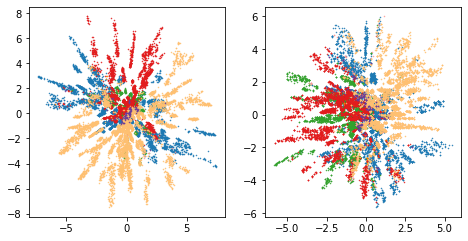

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

embeddings = []
idx_mappers = []
for idx,model in enumerate(models):
    embedding, idx_mapper = plot_embeddings(model, labels, ax=ax[idx])
    embeddings.append(embedding)
    idx_mappers.append(idx_mapper)

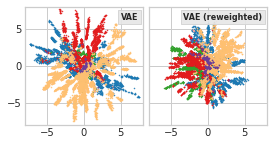

In [7]:
# Create publication figure

import seaborn as sns
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(4, 2.7),sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.0, left=0.0, right=0.99)
for idx,(model, title) in enumerate(zip(models, ["VAE", "VAE (reweighted)"])):
    plot_embeddings(model, labels, ax=ax[idx],
                    precomputed_embeddings=(embeddings[idx], idx_mappers[idx]), xlim=[-8,8], ylim=[-8,8])
    ax[idx].set_aspect('equal')
    plt.yticks([-5,0,5])
    props = dict(boxstyle='square', facecolor="0.9", edgecolor='lightgrey', alpha=0.9, )

    ax[idx].text(0.96, 0.95, title, transform=ax[idx].transAxes, fontsize=8,
                 verticalalignment='top', horizontalalignment='right', bbox=props, fontweight='bold')
    ax[idx].tick_params(axis='x', labelsize=10)
    ax[idx].tick_params(axis='y', labelsize=10)
    ax[idx].tick_params(axis='both', which='major', pad=-3)

plt.savefig('vae_normal_vs_reweighted.pdf',bbox_inches='tight')

## Entropy plot

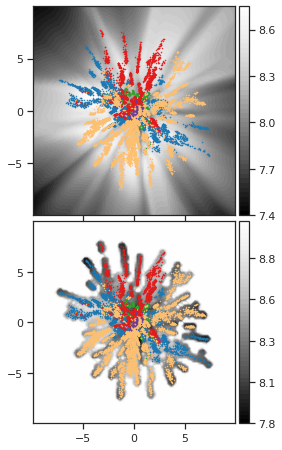

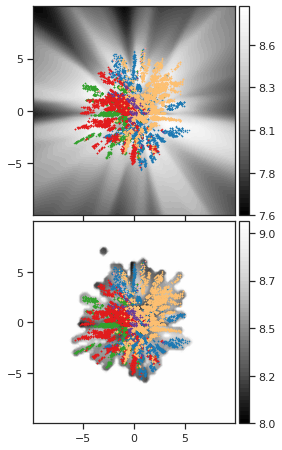

In [8]:
import torch.distributions as D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

import seaborn as sns
custom_style = {'grid.color': '0.5'}
sns.set_theme(style="ticks")

n_points = 100
xy_min, xy_max = -10,10

z_grid = torch.stack([m.flatten() for m in torch.meshgrid(2*[torch.linspace(xy_min,xy_max,n_points)])]).t()

for idx1, model in enumerate(models):
    fig, ax = plt.subplots(2, 1, figsize=(4, 8), sharex=True)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.01, wspace=None)

    # Plot with and without entropy network enabled
    for idx2, model_switch in enumerate([False, True]):
        model.switch=model_switch
        recon = models[idx1].decode(z_grid, as_probs=True)
        d = D.Categorical(probs=recon.permute(0,2,1))
        var1 = d.entropy().sum(dim=-1)

        plot_embeddings(model, labels, ax=ax[idx2],
                       precomputed_embeddings=(embeddings[idx1], idx_mappers[idx1]))
        c = ax[idx2].contourf(z_grid[:,0].reshape(n_points, n_points),
                      z_grid[:,1].reshape(n_points, n_points),
                      var1.log().reshape(n_points, n_points).detach(), levels=50, cmap='Greys_r', zorder=0)
        ax[idx2].set_xlim([xy_min, xy_max])
        ax[idx2].set_ylim([xy_min, xy_max])

        ax[idx2].set_xticks([-5,0,5])
        ax[idx2].set_yticks([-5,0,5])
        ax[idx].set_aspect('equal')

        divider = make_axes_locatable(ax[idx2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb = fig.colorbar(c, cax=cax, orientation='vertical', format="%.1f")
        cb.ax.locator_params(nbins=5)
    plt.savefig('vae_entropy_{}.pdf'.format(idx1), bbox_inches='tight')


## Phylogenetic tree

In [9]:
# Options
run_preprocessing = False

def calculate_or_predict_tree(filename, run_processing):

    phylo_ids = []
    for record in SeqIO.parse(filename, "fasta"):
        phylo_ids.append(record.id.split('/')[0])

    output_filename = filename.replace(".fasta", "_tree.txt")
        
    if run_preprocessing:

        !FastTree &> /dev/null
        if _exit_code != 0:

            # Attempt at making script self-contained by installing FastTree via conda. 
            # Seems to work on colab, but might not be super robust
            !conda --version
            if _exit_code != 0:
                !pip install -q condacolab
                import condacolab
                condacolab.install()

            !conda install -y -c bioconda fasttree 

        # Estimate tree
        # !FastTree < PF00144_full.txt > PF00144_tree.txt
        !FastTree < $filename > $output_filename

    else:
        # Retrieve Beta-lactamase tree file
        if not os.path.exists(output_filename):
            url = "https://sid.erda.dk/share_redirect/a5PTfl88w0/" + output_filename
            !wget --no-check-certificate $url
                
calculate_or_predict_tree("PF00144_full_labeled.fasta", run_preprocessing)
# calculate_or_predict_tree("BLAT_ECOLX_1_b0.5_labeled.fasta", run_preprocessing)

In [10]:
try:
    from Bio import Phylo
except:
    !pip install biopython
    from Bio import Phylo

class TreeDist(object):
    def __init__(self, filename):
        self.tree = next(Phylo.parse(filename, 'newick'))
        self.leaves = list(self.tree.get_terminals())
        
        self.leaf_lookup = {}
        for i, leaf in enumerate(self.leaves):
            self.leaf_lookup[leaf.name] = i

    def id_to_id_dist(self, id1, id2):

        idx1 = self.leaf_lookup[id1]
        idx2 = self.leaf_lookup[id2]

        return self.tree.distance(self.leaves[idx1],
                                  self.leaves[idx2])
    
td = TreeDist("PF00144_tree.txt")
# td = TreeDist("BLAT_ECOLX_1_b0.5_labeled_tree.txt")

print("Leaves: ", len(td.leaves))

Leaves:  36328


In [11]:
import scipy.stats
import pandas as pd

def initializing_curve_length(model, curve):
    # Function passed to FastDiscreteManifold for initialization
    # Use entropy network output s as a proxy for the entropy along the curve
    _, s = model.decode(curve, return_s=True)
    weight = s.squeeze().mean(dim=-1)
    return weight

def create_discretized_manifold(model, n_points=100, grid_min=-8, grid_max=8, sample_around_grid_points = False):
    
    # Create grid and calculate discretized version of manifold, so that geodesics can be calculated using
    # graph algorithm
    z_grid = torch.stack([m.flatten() for m in torch.meshgrid(2*[torch.linspace(grid_min, grid_max,n_points)])]).t()

    if sample_around_grid_points:
        # Sample around grid points, allowing grid points to move off the original grid towards area of lower entropy
        n_samples = 10
        resolution = (grid_max-grid_min)/n_points
        z_grid_sampled = torch.distributions.Normal(loc=z_grid, scale=z_grid*0+resolution/2).sample([n_samples])
        decoded = D.Categorical(probs=model.decode(z_grid_sampled, as_probs=True).permute(0,1,3,2))
        z_grid = z_grid_sampled[decoded.entropy().sum(dim=-1).argmin(dim=0), 
                                torch.arange(0, z_grid_sampled.shape[1])]

    from models.geoml.manifold import EmbeddedManifold, CubicSpline
    from models.geoml.discretized_manifold import FastDiscretizedManifold
    return FastDiscretizedManifold(model, z_grid.t().reshape(2,n_points,n_points), 
                                   use_diagonals=True, batch_size=256,
                                   external_curve_length_function=initializing_curve_length)    
dms = []
for i, model in enumerate(models):
    print('\n Creating discretized manifolds', i)
    dms.append(create_discretized_manifold(model))


 Creating discretized manifolds 0

 Creating discretized manifolds 1


In [12]:
from scipy import interpolate
from scipy.special import softmax
from models.geoml.curve import BasicCurve

class SplineApprox(BasicCurve):
    def __init__(self, discreate_curve):
        self.device = discreate_curve.device
        out = discreate_curve(torch.linspace(0,1,100)).detach()
        x, y = out.T
        self.f, _ = interpolate.splprep([tuple(xi for xi in x), tuple(yi for yi in y)], k=5)

    def __call__(self, t):
        xint, yint = interpolate.splev(t, self.f)
        return torch.stack([torch.tensor(xint), torch.tensor(yint)]).T.float()
        
n_samples = 500
n_repetitions = 5
distances = []
for idx in range(n_repetitions):
    
    # Random indices
    # weight sampling by each points norm to center
    sample_idx_i = []
    sample_idx_j = []
    
    model = models[0]    
    weights = softmax(np.linalg.norm(embeddings[0], ord=2, axis=-1))
    sample_idx_i = np.random.choice(len(models[0].train_dataloader().dataset), size=n_samples, replace=False, p=weights)
    sample_idx_j = np.random.choice(len(models[0].train_dataloader().dataset), size=n_samples, replace=False, p=weights)
    
    print('\n Calculating phylogenetic distances')
    embedded_ids = np.array(ids)[idx_mappers[0]]    
    phylo_distances = []
    for i, j in zip(sample_idx_i, sample_idx_j):
        phylo_distances.append(td.id_to_id_dist(embedded_ids[i], 
                                                embedded_ids[j]))
        
    print('\n Calculating VAE distances')
    vae_distances = []
    for i, j in zip(sample_idx_i, sample_idx_j):
        em1 = embeddings[0][i]
        em2 = embeddings[0][j]
        vae_distances.append(np.linalg.norm(em1-em2))

    print('\n Calculating VAE geodesics')
    vae_geo_distances = []
    for i, j in zip(sample_idx_i, sample_idx_j):
        em1 = embeddings[0][i]
        em2 = embeddings[0][j]
        curve, dist = dms[0].shortest_path(em1, em2)
        
        if curve.num_nodes >2: 
            curve = numeric_curve_optimizer(models[0], curve)
        if i != j and dms[0].grid_point(em1) != dms[0].grid_point(em2):
            curve = SplineApprox(curve)
            
        dist = float(models[0].curve_length(curve(torch.linspace(0, 1, 100))))
        vae_geo_distances.append(dist)
        
    print('\n Calculating Hamming distances')
    embedded_data = data[idx_mappers[0]]
    hamming_distances = []
    for i, j in zip(sample_idx_i, sample_idx_j):
        hamming_distances.append(scipy.spatial.distance.hamming(embedded_data[i], embedded_data[j]))
        
    print('\n Calculating expected Hamming distances')
    exp_hamming_distances = []
    for i, j in zip(sample_idx_i, sample_idx_j):
        em1 = embeddings[0][i]
        em2 = embeddings[0][j]
        dec1 = torch.distributions.Categorical(models[0].decode(torch.tensor(em1).reshape(1,-1), as_probs=True).permute(0,2,1))
        dec2 = torch.distributions.Categorical(models[0].decode(torch.tensor(em2).reshape(1,-1), as_probs=True).permute(0,2,1))
        exp_hamming_distances.append(np.mean([scipy.spatial.distance.hamming(dec1.sample(), dec2.sample()) for _ in range(20)]))
            
        
    distances.append({'vae':(vae_distances, phylo_distances),
                      'vae_geo':(vae_geo_distances, phylo_distances), 
                      'hamming':(hamming_distances, phylo_distances),
                      'exp hamming': (exp_hamming_distances, phylo_distances)})

# Model trained with reweighted sequences
for idx in range(n_repetitions):
    
    # Random indices
    # weight sampling by each points norm to center
    sample_idx_i = []
    sample_idx_j = []
    
    model = models[1]
    weights = softmax(np.linalg.norm(embeddings[1], ord=2, axis=-1))
    sample_idx_i = np.random.choice(len(models[1].train_dataloader().dataset), size=n_samples, replace=False, p=weights)
    sample_idx_j = np.random.choice(len(models[1].train_dataloader().dataset), size=n_samples, replace=False, p=weights)
    
    print('\n Calculating phylogenetic distances')
    embedded_ids = np.array(ids)[idx_mappers[1]]    
    phylo_distances = []
    for i, j in zip(sample_idx_i, sample_idx_j):
        phylo_distances.append(td.id_to_id_dist(embedded_ids[i], 
                                                embedded_ids[j]))
        
    print('\n Calculating VAE distances (reweighted)')
    vae_distances = []
    for i, j in zip(sample_idx_i, sample_idx_j):
        em1 = embeddings[1][i]
        em2 = embeddings[1][j]
        vae_distances.append(np.linalg.norm(em1-em2))

    print('\n Calculating VAE geodesics (reweighted)')
    vae_geo_distances = []
    for i, j in zip(sample_idx_i, sample_idx_j):
        em1 = embeddings[1][i]
        em2 = embeddings[1][j]
        curve, dist = dms[1].shortest_path(em1, em2)
        
        if curve.num_nodes >2: 
            curve = numeric_curve_optimizer(models[1], curve)
        if i != j and dms[1].grid_point(em1) != dms[1].grid_point(em2):
            curve = SplineApprox(curve)
            
        dist = float(models[1].curve_length(curve(torch.linspace(0, 1, 100))))
        vae_geo_distances.append(dist)
        
    distances[idx].update({'vae_w':(vae_distances, phylo_distances),
                           'vae_w_geo':(vae_geo_distances, phylo_distances)})    
    
distances = pd.DataFrame(distances)
distances.to_json("distance_calculations.json")


 Calculating phylogenetic distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating Hamming distances

 Calculating expected Hamming distances

 Calculating phylogenetic distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating Hamming distances

 Calculating expected Hamming distances

 Calculating phylogenetic distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating Hamming distances

 Calculating expected Hamming distances

 Calculating phylogenetic distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating Hamming distances

 Calculating expected Hamming distances

 Calculating phylogenetic distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating Hamming distances

 Calculating expected Hamming distances

 Calculating phylogenetic distances

 Calculating VAE distances (reweighted)

 Calculating VAE geodesics (reweighted)

 Calculating phylogenetic distances

 Calculating 

6
vae Pearson: 0.56 ± 0.02
Spearman: 0.48 ± 0.02
vae_geo Pearson: 0.66 ± 0.04
Spearman: 0.44 ± 0.02
hamming Pearson: 0.73 ± 0.03
Spearman: 0.39 ± 0.03
exp hamming Pearson: 0.73 ± 0.03
Spearman: 0.40 ± 0.03
vae_w Pearson: 0.44 ± 0.02
Spearman: 0.36 ± 0.02
vae_w_geo Pearson: 0.51 ± 0.02
Spearman: 0.36 ± 0.02


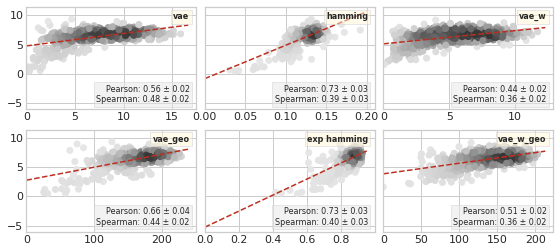

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import gaussian_kde
import matplotlib.colors as colors
import scipy.stats
import seaborn as sns
sns.set_theme(style="whitegrid")

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

red = [.74, .18, .12]
yellow = "#fff6d5"
cmap = truncate_colormap(plt.get_cmap('gray_r'), 0.1, 0.80)


fig, ax = plt.subplots(2, len(distances.columns)//2, sharex=False, sharey=True, figsize=(8,4.))
plt.subplots_adjust(wspace=0.05, hspace=0.2, left=0.075, right=0.99, bottom=0.2, top=0.98)

print(len(distances.columns))

for idx, model in enumerate(distances.columns):
    
    idx = idx%2, idx//2
    
    datapoints = np.array(distances[model].to_list())
    
    spearmans = []
    pearsons = []
    for repetition in range(datapoints.shape[0]):
        
        x = datapoints[repetition,0]
        y = datapoints[repetition,1]
        
        spearmans.append(scipy.stats.spearmanr(x, y).correlation)
        pearsons.append(np.corrcoef(x,y)[0,1])

    corr_str = """Pearson: {:.2f} ± {:.2f}\nSpearman: {:.2f} ± {:.2f}""".format(np.mean(pearsons), 
                                                                                np.std(pearsons), 
                                                                                np.mean(spearmans), 
                                                                                np.std(spearmans))
    
    print(model, corr_str)
    
    # Visualize first repetition
    x = datapoints[0,0]
    y = datapoints[0,1]
    
    xy = np.vstack([x,y])

    z = gaussian_kde(xy)(xy)


    title = model

    ax[idx].scatter(x, y, c=z, cmap=cmap)

    line_x = np.linspace(0, ax[idx].get_xlim()[1], 500)

    coef = np.polyfit(x,y,1)
    line_y = np.poly1d(coef)(line_x)
    
    ax[idx].plot(line_x, line_y, '--', color=red)

    ax[idx].tick_params(axis='both', which='major', pad=-3)
    
    props = dict(boxstyle='square', facecolor=yellow, edgecolor='lightgrey', alpha=0.5, )

    ax[idx].text(0.96, 0.95, title, transform=ax[idx].transAxes, fontsize=8, verticalalignment='top', horizontalalignment='right', bbox=props, fontweight='bold')

    props = dict(boxstyle='square', facecolor="0.9", edgecolor='lightgrey', alpha=0.5)

    ax[idx].text(0.96, 0.05, corr_str, transform=ax[idx].transAxes, fontsize=8, verticalalignment='bottom', horizontalalignment='right', bbox=props)

    ax[idx].set_xlim(left=0)

## Ancestral reconstruction

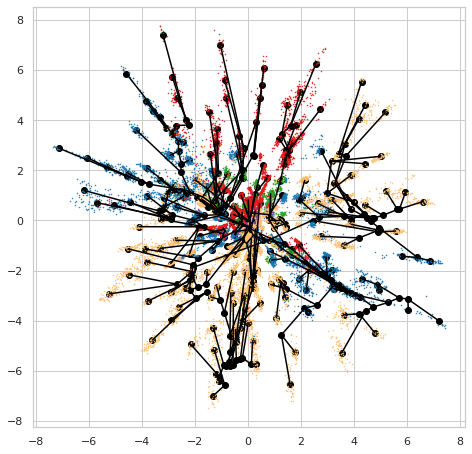

In [14]:
# Options
run_preprocessing = False

representative_point_labels = ['A0A1S9B261_9BACT', 'A0A1N6S5V9_9SPHI', 'A0A0G3XB70_9SPHN', 'A0A124H8F2_9ACTN', 'A0A0H0XMZ2_9SPHN', 'A0A1H3MS29_9MICO', 'A0A1C4RXZ6_9ACTN', 'K6YB53_9ALTE', 'D7BUJ0_STRBB', 'V4PEL1_9CAUL', 'A0A0R2T7U0_9GAMM', 'W6TRC3_9SPHI', 'A0A095V1K0_9FLAO', 'H5UKC9_9ACTN', 'A0A086GHA9_STRSC', 'I0K217_9BACT', 'A0A1E5SZ29_9BACT', 'A0A162YSP3_9FLAO', 'A0A1J4NQQ5_9ACTN', 'U5VSN6_9ACTN', 'A0A1C4SSD9_9ACTN', 'A0A1W9IDH3_9PROT', 'A0A142HQP5_9SPHI', 'A0A1S1R3M6_9ACTN', 'A0A1I1BJF2_9RHIZ', 'U5EQF0_NOCAS', 'A0A0X3XPR2_9ACTN', 'H6R079_NOCCG', 'A0A117P596_9ACTN', 'A0A1A1WA84_9MYCO', 'A0A0P1E0C4_9RHOB', 'A0A1A1W888_9MYCO', 'A0A1H7JGC4_9FLAO', 'A0A239H288_9ACTN', 'A0A1Q3TL54_9SPHI', 'K4KU84_SIMAS', 'A0A1I5UY06_9BURK', 'R1I1M6_9PSEU', 'Q1QJW4_NITHX', 'A0A132PRK9_9MYCO', 'A0A1U9RJ97_9PROT', 'A0A1M7RYP7_9SPHN', 'A0A1B2AFT2_9SPHN', 'A0A0A0M5Y1_9GAMM', 'A0A0F5VWV8_9ACTN', 'I2GLG1_9BACT', 'A0A0F7FX81_9ACTN', 'A0A1G8H815_9FLAO', 'A0A1X1XXI8_9MYCO', 'A0A239D989_9ACTN', 'A0A1V6MS15_9ACTN', 'A0A1H5P1R8_9ACTN', 'A0A1I5FZY5_9PSEU', 'A0A0X8G8M6_9FLAO', 'A0A0B4C4Z4_9RHOB', 'A0A1A3JFC6_9MYCO', 'F6FTL6_ISOV2', 'R6TPJ2_9FIRM', 'A0A0A8E0Q6_9XANT', 'A0A1I7E112_9BURK', 'A0A1I0K8Y1_9ACTN', 'A0A1Q5RAV8_9BRAD', 'A6GGG0_9DELT', 'F9UGM4_9GAMM', 'C1AR94_RHOOB', 'A0A1M5PIZ9_9PSED', 'A4YSH1_BRASO', 'A0A1C5D6B7_9ACTN', 'A0A1B9SCE0_9RHIZ', 'A0A1H5RFB9_9PSEU', 'A0A1H6K407_9FLAO', 'A0A1I5LQF8_9PSEU', 'A0A101P567_9ACTN', 'A0A1W9HH69_9PROT', 'A0A1C5GGB8_9ACTN', 'A0A1H9UFK4_9PSEU', 'C6XX09_PEDHD', 'A0A1N7D2Y2_9SPHI', 'A0A0M9ZF93_9ACTN', 'A0A1I3JVY2_9FLAO', 'A0A1Q5XM94_9BACL', 'A0A086GTC1_STRSC', 'A0A0Q3PHY5_9BRAD', 'X5L994_9MYCO', 'A8FUC9_SHESH', 'A0A1Q4AJT7_9RHIZ', 'A0A1R0U5T5_9MYCO', 'A0A239E4N3_9SPHN', 'A0A1W9Z6U0_9MYCO', 'A0A1E7N9T9_KITAU', 'A0A0D8ZT94_9CYAN', 'U5W069_9ACTN', 'A0A1X1TEX7_9MYCO', 'E3IVP0_FRAIE', 'A0A238W6P2_9FLAO', 'A0A0S2KGP0_9GAMM', 'A0A150X572_9BACT', 'A0A0P1HDX4_9RHOB', 'A0A1X1Y8Z0_9MYCO', 'A0A1T3NKX6_9ACTN', 'A0A1E5T8M3_9FLAO', 'W6RMK2_9RHIZ', 'D2QF15_SPILD', 'A0A172YP11_9GAMM', 'A0A1G9IS36_9FIRM', 'A0A0P0NER0_9SPHI', 'A0A1H2Z8U6_9FLAO', 'I4N9E9_9PSED', 'H6NNS0_9BACL', 'A0A0Q6U7Q0_9CAUL', 'A0A1I1NQA5_9FLAO', 'W6K0N3_9MICO', 'A0A059FAG0_9RHOB', 'A0A239UAQ6_9STAP', 'A0A0Q4CCW5_9SPHN', 'A0A1H7Z0C3_9BACL', 'I8XTV4_9BACE', 'A0A0Q9SNL5_9MICO', 'A0A0L0KUC6_9ACTN', 'A0A1M3DBI3_9SPHN', 'A0A0Q4CCV4_9FLAO', 'A0A0Q6LBM4_9RHIZ', 'A0A0D6P7R6_9PROT', 'A0A2D8REK4_9GAMM', 'A0A1I6MH08_9MICO', 'A0A1Z2KUI0_9ACTN', 'A5FKQ3_FLAJ1', 'A0A1I1L7I8_9GAMM', 'A0A1G9VIM6_9PSEU', 'A0A0K2YPP4_9NOCA', 'A0A172ZMD5_9BACL', 'A0A117P8A7_9ACTN', 'A0A0M2VW43_9BACL', 'A0A1X7LEJ3_9BACT', 'A0A1G8MTV3_9BRAD', 'A0A1G9UIX5_9ACTN', 'A0A2G1UKI9_9ALTE', 'A0A1I4ZAY4_9ACTN', 'A0A091BUD4_9ENTE', 'A0A1G9SC39_9BACT', 'A0A117QQC3_9ACTN', 'A0A246JGM2_9SPHN', 'G2YZY5_FLABF', 'A0A1A1XCB1_9MYCO', 'A0A1G6EYF3_9FLAO', 'A0A1W1UTZ2_9DEIO', 'A0A1H0LUA7_9PSEU', 'A0A0D7N702_9BRAD', 'A0A139V867_MYCPH', 'A0A0Q7T9N7_9CAUL', 'A0A075P8I6_9ALTE', 'F5XN73_MICPN', 'A0A1N6TB30_9ACTN', 'A0A0S2F7W1_9GAMM', 'A0A0W1FDQ5_9SPHN', 'A0A1F4HNF0_9BURK', 'A0A0S7B6I6_9CHLR', 'A0A1M7RNK4_9ACTN', 'D9VTC3_9ACTN', 'A0A1I4H5E7_9BACI', 'A0A1I6MHH8_9MICO', 'A0A0N1C0K0_9SPHN', 'A0A0S7BU80_9BACT', 'A0A1E5UCX4_9FLAO', 'A0A0T1QBY4_9ACTN', 'A0A1I7HTB7_9BRAD', 'A0A0J8YTA7_9BACT', 'A0A0Q5LNR9_9MICO', 'W6RC31_9RHIZ', 'A0A1H9IED7_9GAMM', 'A0A2C9XTS2_9ENTE', 'A0A0A7JHS1_9PSED', 'A0A0G3M0P2_9FLAO', 'A0A257J7M5_9PROT', 'A0A0Q4RYS2_9FLAO', 'A0A0X8E1F4_9MICO', 'A0A1H3JYW4_9ACTN', 'A0A1S8D874_9PROT', 'A0A1K2FJD7_9ACTN', 'A0A0M8XWS4_9ACTN', 'A0A1L7D1X1_9CORY', 'A0A0S2K5Z8_9GAMM', 'A0A1C2EAC3_9RHIZ', 'A0A086N7F9_9ACTN', 'A0A172TI00_9BACL', 'A0A1N7N8U5_9RHOB', 'A0A127JZQ8_9BURK', 'A0A0Q4MDP1_9GAMM', 'A0A074M2K7_9SPHN', 'A0A1S6FJP8_9SPHN', 'A0A1R1SC01_9ACTN', 'A0A1A3MVE7_MYCAS', 'B0T1W0_CAUSK', 'A0A0Q5UMQ3_9FLAO', 'K0ELR6_9NOCA', 'C9ZH94_STRSW', 'A0A100Y6W1_9ACTN', 'A0A1H4IQL5_9FLAO', 'A0A0M8XHR7_9ACTN', 'A0A1A1Y6V6_9MYCO']

if run_preprocessing:

    from Bio import AlignIO
    from Bio.Align import MultipleSeqAlignment
    import io
    import copy
    import re
    import numpy as np
    
    # Create small alignment only with representative sequences
    records = []
    counter = 1
    for record in SeqIO.parse("PF00144_full_labeled.fasta", "fasta"):
        if record.id.split('/')[0] in representative_point_labels:
            record.id = "node%02d_%s" % (counter, record.id)
            records.append(record)
            counter += 1
    with open("PF00144_full_representatives.fasta", "w") as output_handle:
        SeqIO.write(records, output_handle, "fasta")

    # Fix gap symbols
    with open("PF00144_full_representatives.fasta") as alignment_file:
        contents = alignment_file.read()
        contents = contents.replace('.', '-')
    alignment = AlignIO.read(io.StringIO(contents), "fasta")

    # Remove columns which have only gaps
    compact_alignment = None
    removed_columns = []
    gap_column = None
    for j in range(alignment.get_alignment_length()):
        if alignment[:,j].count('-') != len(alignment):
            if compact_alignment is None:
                compact_alignment = alignment[:,j:j+1]
            else:
                compact_alignment += alignment[:,j:j+1]
        else:
            removed_columns.append(j)
            gap_column = copy.copy(alignment[:,j:j+1])
    AlignIO.write(compact_alignment, "PF00144_full_representatives_compact.fasta", "fasta")

    # Create tree
    command = "FastTree < %s > %s" % ("PF00144_full_representatives_compact.fasta", 
                                        "PF00144_full_representatives_compact.tree")
    !$command
    
    if not os.path.exists('convert_fasta2phylip.py'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/convert_fasta2phylip.py
            
    # Convert fasta to phylip
    %run convert_fasta2phylip.py PF00144_full_representatives_compact.fasta PF00144_full_representatives_compact.phy

    # Run codeml from the PAML package
    if not os.path.exists('paml4.9j'):
        !wget http://abacus.gene.ucl.ac.uk/software/paml4.9j.tgz
        !tar xvf paml4.9j.tgz
        %cd paml4.9j/src
        !make
        %cd ../..
        
    # Retrieve codeml control file
    if not os.path.exists('control_file.ctl'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/control_file.ctl
    
    # Run reconstruction
    !paml4.9j/src/codeml control_file.ctl
    
    # Extract ancestral sequences
    if not os.path.exists('parse_rst'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/parse_rst
    command = "python parse_rst.py rst > PF00144_full_representatives_compact_ancestral.fasta" 
    !$command

    # Reinsert original gaps
    alignment_compact = AlignIO.read("PF00144_full_representatives_compact_ancestral.fasta", "fasta")
    alignment_final = None
    compact_index = 0
    # gap_column = copy.copy(alignment_compact[:,0])
    # gap_column[:,:] = '-'
    gap_column = gap_column[:len(alignment_compact)]
    for j in range(alignment.get_alignment_length()): # Note, using original alignment here for total length
        print("j=%s" %j)
        if j in removed_columns:
            if alignment_final is None:
                alignment_final = copy.copy(gap_column)
            else:
                alignment_final += copy.copy(gap_column)
        else:
            if alignment_final is None:
                alignment_final = alignment_compact[:,compact_index:compact_index+1]
            else:
                alignment_final += alignment_compact[:,compact_index:compact_index+1]
            compact_index += 1

    for i,row in enumerate(alignment_final):
        row.id = alignment_compact[i].id
        row.description = alignment_compact[i].description

    AlignIO.write(alignment_final, "PF00144_full_representatives_ancestral.fasta", "fasta")

    # Extract edge-info from rst file
    pattern = re.compile(r'\s*(\d+..\d+\s+)+')
    with open("rst") as infile:
        tree_str = pattern.search(infile.read()).group(0)
        ancestral_edges = np.array([[int(element)-1 for element in pair.split('..')] for pair in tree_str.split()])
        np.save("ancestral_edges.npy", ancestral_edges)
    
else:

    if not os.path.exists("PF00144_full_representatives.fasta"):
        !wget --no-check-certificate https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_representatives.fasta

    if not os.path.exists("PF00144_full_representatives_ancestral.fasta"):
        !wget --no-check-certificate https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_representatives_ancestral.fasta

    if not os.path.exists("ancestral_edges.npy"):
        !wget --no-check-certificate https://sid.erda.dk/share_redirect/a5PTfl88w0/ancestral_edges.npy


ancestral_ids = []
ancestral_seqs = []
for record in SeqIO.parse("PF00144_full_representatives.fasta", "fasta"):
    ancestral_ids.append(record.id)
    ancestral_seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
for record in SeqIO.parse("PF00144_full_representatives_ancestral.fasta", "fasta"):
    ancestral_ids.append(record.id)
    ancestral_seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
ancestral_seqs = torch.from_numpy(np.vstack(ancestral_seqs))

ancestral_embeddings = []
for model in models:
    ancestral_embeddings.append([])
    batchsize = 16
    n_batch = int(np.ceil(ancestral_seqs.shape[0] / batchsize))
    for b in range(n_batch):
        batch = ancestral_seqs.data[b*batchsize:(b+1)*batchsize]
        zs = model.embedding(batch.long().to(model._device))
        ancestral_embeddings[-1].append(zs.detach())
    ancestral_embeddings[-1] = np.vstack(ancestral_embeddings[-1])

fig = plt.figure(figsize=(8,8))
plot_embeddings(model, labels, plt.gca(), 
                precomputed_embeddings=(embeddings[0], idx_mappers[0]))
    
plt.scatter(ancestral_embeddings[0][:,0], ancestral_embeddings[0][:,1], color='black')

ancestral_edges = np.load('ancestral_edges.npy')
for edge in ancestral_edges:
    p1 = ancestral_embeddings[0][edge[0]]
    p2 = ancestral_embeddings[0][edge[1]]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black')

## Visualizing geodesics

In [18]:
from scipy.special import softmax
from copy import deepcopy
    
n_curves = 1000

# weight sampling by each points norm to center
embeddings_norm = softmax(np.linalg.norm(embeddings[0], ord=2, axis=-1))
idx = np.random.choice(embeddings[0].shape[0], size=2*n_curves, replace=False, p=embeddings_norm)
curve_point_list = []
for idx, (i,j) in enumerate(zip(idx[:n_curves], idx[n_curves:])):   
    if idx%100 ==0:
        print(idx)
        
    em1 = torch.tensor(embeddings[0][i])
    em2 = torch.tensor(embeddings[0][j])
    curve, dist = dms[0].shortest_path(em1, em2)
    
    if curve.num_nodes >2: 
        curve = numeric_curve_optimizer(models[0], curve)
    if i != j and dms[0].grid_point(em1) != dms[0].grid_point(em2):
        curve = SplineApprox(curve)

    curve_point_list.append(curve(torch.linspace(0,1,101)).detach())

0
100
200
300
400
500
600
700
800
900


<Figure size 576x576 with 0 Axes>

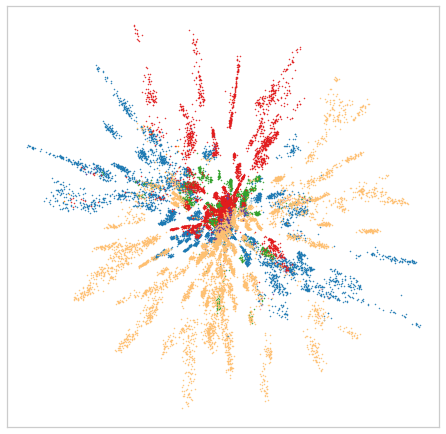

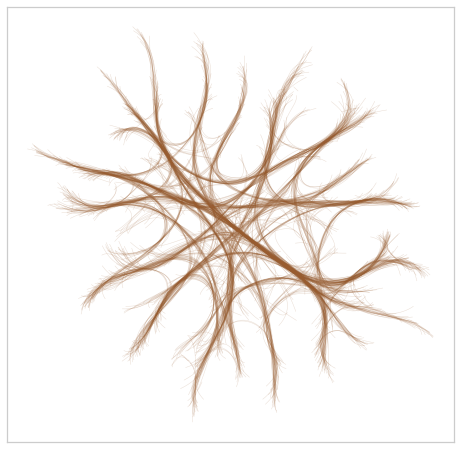

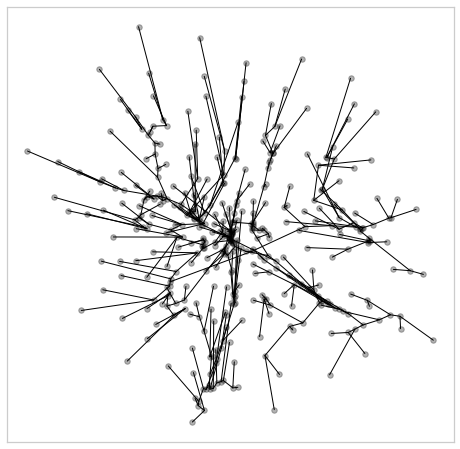

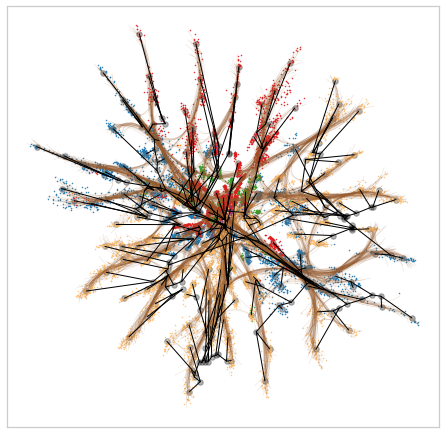

In [19]:
fig = plt.figure(figsize=(8,8))

# geodesic color
color_geodesics = "#985C2F"

def plot_embedding_layer():
    plot_embeddings(model, labels, plt.gca(), 
                    precomputed_embeddings=(embeddings[0], idx_mappers[0]))
    
def plot_geodesics_layer():
    for points in curve_point_list:
        plt.plot(points[:,0], points[:,1], color=color_geodesics, alpha=0.2, linewidth=0.5)
    
def plot_tree_layer():
    plt.scatter(ancestral_embeddings[0][:,0], ancestral_embeddings[0][:,1], color='black', alpha=0.3, s=30)

    ancestral_edges = np.load('ancestral_edges.npy')
    
    for edge in ancestral_edges:
        p1 = ancestral_embeddings[0][edge[0]]
        p2 = ancestral_embeddings[0][edge[1]]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black', linewidth=1.0)
        
        
fig = plt.figure(figsize=(8,8))    
plt.gca().xaxis.set_ticks([])
plt.gca().yaxis.set_ticks([])
plot_embedding_layer()    
plt.savefig("geodesic_plot_embedding.svg")

fig = plt.figure(figsize=(8,8))
plt.gca().xaxis.set_ticks([])
plt.gca().yaxis.set_ticks([])
plot_geodesics_layer()
plt.savefig("geodesic_plot_geodesics.svg")
    
fig = plt.figure(figsize=(8,8))
plt.gca().xaxis.set_ticks([])
plt.gca().yaxis.set_ticks([])
plot_tree_layer()
plt.savefig("geodesic_plot_tree.svg")
    

fig = plt.figure(figsize=(8,8))
plt.gca().xaxis.set_ticks([])
plt.gca().yaxis.set_ticks([])
plot_embedding_layer()    
plot_geodesics_layer()
plot_tree_layer()
plt.savefig("geodesic_plot_all.svg")

## Robustness of distances over training instances

In [20]:
# Training 4 additional repetitions of models

# Options
train_models = False

models = [[models[0]], [models[1]]]
for rep in range(4):

    seed = 123+rep+1
    model_pf00144 = train_or_retrieve_model('model_PF00144_r{}'.format(rep), 
                                            data,
                                            weights=None,
                                            epochs=20,
                                            seed=seed,
                                            train_model=train_models,
                                            uncertainty_temperature=-3.5,
                                            mask_out_gaps=True)
    model_pf00144_reweighted = train_or_retrieve_model('model_PF00144_reweighted_0.8_r{}'.format(rep), 
                                                       data,
                                                       weights=weights,
                                                       epochs=20,
                                                       seed=seed,
                                                       train_model=train_models,
                                                       uncertainty_temperature=-3.5,
                                                       mask_out_gaps=True)
    models[0].append(model_pf00144)
    models[1].append(model_pf00144_reweighted)

Global seed set to 124


Loading from checkpoint!


Global seed set to 124


Loading from checkpoint!


Global seed set to 125


Loading from checkpoint!


Global seed set to 125


Loading from checkpoint!


Global seed set to 126


Loading from checkpoint!


Global seed set to 126


Loading from checkpoint!


Global seed set to 127


Loading from checkpoint!


Global seed set to 127


Loading from checkpoint!


In [21]:
# Calculate embeddings of data set for all repeated training of models
embeddings_rep = []
for i, model_type in enumerate(models):
    embeddings_rep.append([])
    for j, model in enumerate(model_type):
        print(i,j)        
        batch_size = 256
        n_batch = int(np.ceil(len(data) / batch_size))
        emb = []
        for b in range(n_batch):
            batch = data[b*batch_size:(b+1)*batch_size]
            emb.append(model.embedding(batch.long().to(model._device)).detach().cpu().numpy())
        embeddings_rep[i].append(np.vstack(emb))

        # plot_embeddings(model, labels, ax=ax[i,j], precomputer_embeddings=(embeddings[i][j], idx_mappers[i][j]))
        #embedding, idx_mapper = plot_embeddings(model, labels, ax=ax[i,j])
        #embeddings[-1].append(embedding)
        #idx_mappers[-1].append(idx_mapper)

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4


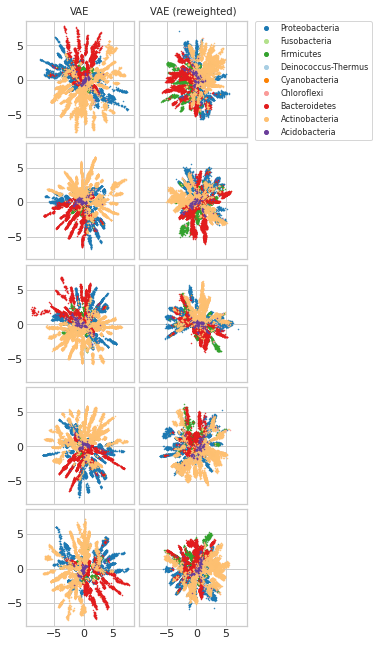

In [22]:
fig, ax = plt.subplots(5, 2, figsize=(6.0, 10), sharex=True, sharey=True)
plt.subplots_adjust(left=0.01, bottom=0, right=0.66, top=0.99, hspace=0.05, wspace=0.05)

for i, model_type in enumerate(models):
    embeddings_rep.append([])
    for j, model in enumerate(model_type):
        legend = True if (i,j) == (1,0) else False
        plot_embeddings(model, labels, ax=ax[j,i], precomputed_embeddings=(embeddings_rep[i][j], None), legend=False)
        ax[j,i].tick_params(axis='both', which='major', pad=-3)
        if j == 0:
            if i==0:
                ax[j,i].set_title("VAE", fontsize=10)
            if i==1:
                ax[j,i].set_title("VAE (reweighted)", fontsize=10)

ax[0,1].legend(markerscale=8, bbox_to_anchor=(1.04,1.035), fontsize=8)
plt.savefig("vae_repetitions.png", dpi=600, bbox_inches='tight')

In [23]:
dms = []
for i, model_type in enumerate(models):
    dms.append([])
    for j, model in enumerate(model_type):        
        print('\n Creating discretized manifolds', i, j)
        dms[-1].append(create_discretized_manifold(model))        


 Creating discretized manifolds 0 0

 Creating discretized manifolds 0 1

 Creating discretized manifolds 0 2

 Creating discretized manifolds 0 3

 Creating discretized manifolds 0 4

 Creating discretized manifolds 1 0

 Creating discretized manifolds 1 1

 Creating discretized manifolds 1 2

 Creating discretized manifolds 1 3

 Creating discretized manifolds 1 4


In [24]:
# To avoid many distances close to the origin dominating, we reweigh samples based on the norm of the embedding vector
# Since we wish to do this analysis over multiple models, we average this norm over the 2x5 models
norms = []
for emb_model_type in embeddings_rep:
    for embedding in emb_model_type:
        norms.append(np.linalg.norm(embedding, ord=2, axis=-1))
norms = np.stack(norms).mean(axis=0)

In [25]:
n_samples = 500
weights = softmax(norms)   
sample_idx_i = np.random.choice(len(data), size=n_samples, replace=False, p=weights)
sample_idx_j = np.random.choice(len(data), size=n_samples, replace=False, p=weights)

model_labels = ["", " (reweighted)"]    
    
# Iterate over model types (unweighted, weighted), and repeated training instances
distances_rep = {"vae":[], 
             "vae (reweighted)":[], 
             "vae geo":[], 
             "vae geo (reweighted)":[],              
             "exp hamming": [],
             "exp hamming (reweighted)": []
            }
for idx1, emb_model_type in enumerate(embeddings_rep):
    for idx2, embedding in enumerate(emb_model_type):
                
        print('\n Calculating VAE distances')
        vae_distances = []
        for i, j in zip(sample_idx_i, sample_idx_j):
            em1 = embedding[i]
            em2 = embedding[j]
            vae_distances.append(np.linalg.norm(em1-em2))
        distances_rep["vae{}".format(model_labels[idx1])].append(vae_distances)

        print('\n Calculating VAE geodesics')
        vae_geo_distances = []
        for i, j in zip(sample_idx_i, sample_idx_j):
            em1 = embedding[i]
            em2 = embedding[j]
            curve, dist = dms[idx1][idx2].shortest_path(em1, em2)

            if curve.num_nodes >2: 
                curve = numeric_curve_optimizer(models[idx1][idx2], curve)
            if i != j and dms[idx1][idx2].grid_point(em1) != dms[idx1][idx2].grid_point(em2):
                curve = SplineApprox(curve)

            dist = float(models[idx1][idx2].curve_length(curve(torch.linspace(0, 1, 100))))
            vae_geo_distances.append(dist)
        distances_rep["vae geo{}".format(model_labels[idx1])].append(vae_geo_distances)
        
        print('\n Calculating expected Hamming distances')
        exp_hamming_distances = []
        for i, j in zip(sample_idx_i, sample_idx_j):
            em1 = embedding[i]
            em2 = embedding[j]
            dec1 = torch.distributions.Categorical(
                models[idx1][idx2].decode(torch.tensor(em1).reshape(1,-1), as_probs=True).permute(0,2,1))
            dec2 = torch.distributions.Categorical(
                models[idx1][idx2].decode(torch.tensor(em2).reshape(1,-1), as_probs=True).permute(0,2,1))
            exp_hamming_distances.append(np.mean([scipy.spatial.distance.hamming(
                dec1.sample(), dec2.sample()) for _ in range(20)]))
        distances_rep["exp hamming{}".format(model_labels[idx1])].append(exp_hamming_distances)
        
distances_rep = pd.DataFrame(distances_rep)
distances_rep.to_json("vae_repeated_distance_calculations.json")


 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating expected Hamming distances


VAE:  0.22573975
VAE (geodesic):  0.10904980670186637
exp Hamming:  0.12858307386021192


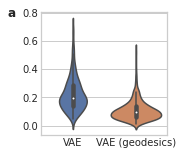

In [26]:
fig = plt.figure(figsize=(2.5,2.1))
plt.subplots_adjust(wspace=0.05, hspace=0.0, left=0.2, right=None, bottom=0.15, top=0.96)
vae_dist = np.array(distances_rep["vae"].tolist())
vae_dist /= vae_dist.mean(axis=0)
print("VAE: ", np.std(vae_dist, axis=0).mean())

vae_geo_dist = np.array(distances_rep["vae geo"].tolist())
vae_geo_dist /= vae_geo_dist.mean(axis=0)
print("VAE (geodesic): ", np.std(vae_geo_dist, axis=0).mean())

exp_hamming_dist = np.array(distances["exp hamming"].tolist())
exp_hamming_dist /= exp_hamming_dist.mean(axis=0)
print("exp Hamming: ", np.std(exp_hamming_dist, axis=0).mean())

sns.violinplot(
    data=pd.DataFrame({'VAE':np.std(vae_dist, axis=0), 
                       'VAE (geodesics)': np.std(vae_geo_dist, axis=0)}),
                          #'exp hamming': np.std(exp_hamming_dist, axis=0)}))
    )#.set_title('Robustness towards retraining', fontsize=10)
plt.gca().tick_params(axis='x', labelsize=10)
plt.gca().tick_params(axis='y', labelsize=10)

props = dict(boxstyle='square', facecolor="0.9", edgecolor='lightgrey', alpha=0.5)
plt.gcf().text(0.01, 0.91, "a", fontsize=12, weight='bold', 
           verticalalignment='bottom', horizontalalignment='left')
plt.gca().tick_params(axis='both', which='major', pad=-3)

plt.savefig('distance_robustness.pdf')

## 30D VAE latent representation

In [27]:
train_models = False

model_pf00144_z30 = train_or_retrieve_model('model_PF00144_z30', 
                                            data,
                                            zdim=30,
                                            epochs=20,
                                            weights=None,
                                            train_model=train_models,
                                            uncertainty_temperature=-3.5,
                                            mask_out_gaps=True)

Global seed set to 123


Loading from checkpoint!


tSNE perplexity:  10.0
tSNE perplexity:  30.0
tSNE perplexity:  100.0


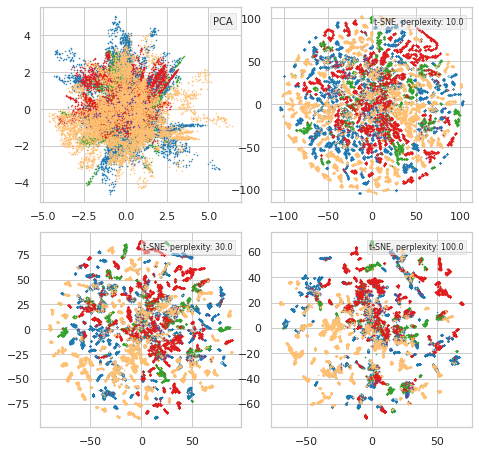

In [28]:
from math import ceil

perplexity_steps = [10., 30., 100.]

figshape = (int(ceil((1+len(perplexity_steps))/2)), 
            int(ceil((1+len(perplexity_steps))/2)))

props = dict(boxstyle='square', facecolor="0.9", edgecolor='lightgrey', alpha=0.5)

fig, ax = plt.subplots(figshape[0], figshape[1], figsize=(4*figshape[0], 4*figshape[1]))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.15, wspace=0.15)
    
embeddings_reduced, idx_mapper_reduced = plot_embeddings(model_pf00144_z30, labels, 
                                                         dimensionality_reduction='pca', ax=ax[0,0])
ax[0,0].text(0.96, 0.9, "PCA", transform=ax[0,0].transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right', bbox=props)

for i, perplexity in enumerate(perplexity_steps):
    fig_i, fig_j = (i+1)//2, (i+1)%2
    print("tSNE perplexity: ", perplexity)
    plot_embeddings(model_pf00144_z30, labels, precomputed_embeddings=(embeddings_reduced, idx_mapper_reduced), 
                    dimensionality_reduction='tsne', tsne_perplexity=perplexity, ax=ax[fig_i, fig_j])

    ax[fig_i, fig_j].text(0.96, 0.9, "t-SNE, perplexity: {}".format(perplexity), transform=ax[fig_i, fig_j].transAxes, fontsize=8,
                          verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.savefig('vae_30d_pca_vs_tsne.png', dpi=600, bbox_inches='tight')